In [22]:
import time
import requests
from bs4 import BeautifulSoup
import pymongo
import pandas as pd
import numpy as np
import re

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
wnlzer = WordNetLemmatizer()


import sys
import os
import csv
import shutil
from collections import defaultdict

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

source_path = 'test_data'
#source_file = 'test_strains_reviews.csv'
target_path = '/Users/jordanweil/green_rex/test_data'

In [23]:
"""reviews = pd.read_csv('test_data/test_strains_reviews.csv')
r = reviews.set_index('Unnamed: 0')"""

"reviews = pd.read_csv('test_data/test_strains_reviews.csv')\nr = reviews.set_index('Unnamed: 0')"

In [24]:
def get_reviews2(l):
    """Pass in a list of URL's and return them in a mongo db table as a dicitonary with 
    {'url', 'html'} and their corresponding values"""
    r = requests.get(l)
    html = (r.content)
    return html

In [25]:
# def get_stars_list(d):
#     stars = []
#     for key, values in d.items():
#         soup = BeautifulSoup(values, 'html.parser')
#         tags = soup.select("div.div.stars")
#         for t in tags:
#             stars.append(t.attrs['style'])
#     return stars

In [26]:
def star_int_conv(s):
    star = (int((s[6:].split(';')[0]).strip('px'))/22)
    
    return star

In [27]:
def list_o_strains(i):
    LOS = []
    Type = []
    r = requests.get(i)
    soup2 = BeautifulSoup(r.content, 'html.parser')
    strains = soup2.find_all('a', class_="ga_Explore_Strain_Tile")
    for s in strains:
        LOS.append(str(s.attrs['href'])[8:])
        Type.append(str(s.attrs['href'])[1:7])
    z = list(zip(LOS,Type))
    return z

In [28]:
def strain_dict_entry(strain, stype, user_id, userstars, userreview, straindict):
    if straindict is None:
        straindict = {}
        
    if strain not in straindict:
        straindict[strain] = {
            "stype" : stype,
            "user_rev" : [] 
        }
        
    straindict[strain]['user_rev'].append({'user':user_id,
                                         'stars':userstars,
                                         'review':userreview
                                        })
    return straindict

In [34]:
def parse_docs2(d):
    """Parse the HTML docs that we have stored in a dictionary, return as a list.
    Also scrape and parse star rating for each review """
    strain_text= []
    star_rate = []
    user_name = []
    
    soup = BeautifulSoup(d, 'html.parser')
    revs = soup.find_all('p',class_='strain-review__text') 
    for r in revs:
        text = r.text
        remove_punch = re.sub('[^A-Za-z ]' , "" ,text )
        token = remove_punch.lower().split()
        srm_token = [wnlzer.lemmatize(i) for i in token if not i in set(stopwords.words('english'))]
        clean_text = " ".join(srm_token)
        strain_text.append(clean_text)
        
    tags = soup.select("div.div.stars")
    for t in tags:
        star = t.attrs['style']
        star_rate.append(star_int_conv(star))
    
    users = soup.find_all('div', class_='strain-review__title')
    for u in users:
        temp = u.find('h2')
        user_name.append(temp.text)
        
    return star_rate, strain_text, user_name

In [35]:
def scraper_dummy1(los):
    """pass in a list of strains to be scraped from Leafly.
    returns dictionary keyed by strains w/strain info(reviews) as values"""
    cnt = 0
    strain_dict = None
    for s in los:
        strain = s[0]
        stype = s[1]
        url = "https://www.leafly.com/{}/{}/reviews?page=".format(stype, strain)
    
        for i in range(1,100):
            rev_url=url+str(i)
            d = get_reviews2(rev_url)
            star, reviews, users = parse_docs2(d)
            #print(star)
            if len(star) == 0:
                break

            for userstars, userreview ,user_id in zip(star, reviews, users):
                strain_dict = strain_dict_entry(strain, stype, user_id, userstars, userreview, strain_dict)
                
            
            if cnt % 10 == 0:
                print(cnt)
            cnt +=1
            
    return strain_dict         

In [36]:
test_strains = list_o_strains('https://www.leafly.com/explore')

In [37]:
test_strains

[('blue-dream', 'hybrid'),
 ('sour-diesel', 'sativa'),
 ('gsc', 'hybrid'),
 ('green-crack', 'sativa'),
 ('og-kush', 'hybrid'),
 ('granddaddy-purple', 'indica'),
 ('original-glue', 'hybrid'),
 ('white-widow', 'hybrid'),
 ('blue-dream', 'hybrid'),
 ('sour-diesel', 'sativa'),
 ('gsc', 'hybrid'),
 ('green-crack', 'sativa'),
 ('og-kush', 'hybrid'),
 ('granddaddy-purple', 'indica'),
 ('original-glue', 'hybrid'),
 ('white-widow', 'hybrid'),
 ('jack-herer', 'sativa'),
 ('bubba-kush', 'indica'),
 ('pineapple-express', 'hybrid'),
 ('trainwreck', 'hybrid'),
 ('ak-47', 'hybrid'),
 ('durban-poison', 'sativa'),
 ('northern-lights', 'indica'),
 ('headband', 'hybrid'),
 ('blue-cheese', 'indica'),
 ('strawberry-cough', 'sativa'),
 ('chemdawg', 'hybrid'),
 ('purple-kush', 'indica'),
 ('lemon-haze', 'sativa'),
 ('super-lemon-haze', 'sativa'),
 ('grape-ape', 'indica'),
 ('blueberry', 'indica'),
 ('alaskan-thunder-fuck', 'sativa'),
 ('super-silver-haze', 'sativa'),
 ('blackberry-kush', 'indica'),
 ('cherry

In [86]:
"""#Only needs to be ran once
d = scraper_dummy1(test_strains)"""

#Already ran it!

'#Only needs to be ran once\nd = scraper_dummy1(test_strains)'

In [39]:
for k in d.keys():
    print(k,len(d[k]['user_rev']))

blue-dream 874
sour-diesel 1004
gsc 560
green-crack 486
og-kush 394
granddaddy-purple 534
original-glue 454
white-widow 286
jack-herer 203
bubba-kush 254
pineapple-express 237
trainwreck 40
ak-47 188
durban-poison 209
northern-lights 179
headband 140
blue-cheese 115
strawberry-cough 140
chemdawg 140
purple-kush 88
lemon-haze 87
super-lemon-haze 121
grape-ape 156
blueberry 111
alaskan-thunder-fuck 96
super-silver-haze 109
blackberry-kush 92
cherry-pie 125
master-kush 69
skywalker-og 30
cheese 38
death-star 85
chocolope 55
amnesia-haze 163
tahoe-og 77
maui-wowie 115
platinum-gsc 74
harlequin 175
gods-gift 76
la-confidential 90
agent-orange 78
purple-urkle 142
lemon-kush 63
mazar-x-blueberry 30
golden-goat 71
afghan-kush 52
dutch-treat 37
hindu-kush 56


In [40]:
d['gsc']['user_rev'][3]

{'user': 'BenchAdventures',
 'stars': 5.0,
 'review': 'ive smoking recently dont need anything youre like youll want make sure floor clear tripping hazard laptop away water etcset snack start smoking make sure youre safe environmenthybrids generally put couch indica gsc make fine motor skill especially hard also especially de'}

In [41]:
def create_files(d):
    cnt = 0
    for strain in d.keys():

        if not os.path.isdir(os.path.join(target_path, strain)):
             os.mkdir(os.path.join(target_path, strain))

        for rev in d[strain]['user_rev']:

            with open(os.path.join(target_path, strain, strain+'{:05d}.txt'.format(cnt)), mode='w') as strain_file:
                strain_file.write(rev['review'])

            cnt += 1

In [42]:
create_files(d)

In [43]:
stopwords_ = "a,able,about,across,after,all,almost,also,am,among,an,and,any,\
are,as,at,be,because,been,but,by,can,could,dear,did,do,does,either,\
else,ever,every,for,from,get,got,had,has,have,he,her,hers,him,his,\
how,however,i,if,in,into,is,it,its,just,least,let,like,likely,may,\
me,might,most,must,my,neither,no,of,off,often,on,only,or,other,our,\
own,rather,said,say,says,she,should,since,so,some,than,that,the,their,\
them,then,there,these,they,this,tis,to,too,twas,us,wants,was,we,were,\
what,when,where,which,while,who,whom,why,will,with,would,yet,you,your]".split(',')

In [77]:
    dataset = load_files(target_path, shuffle=False)
    print('n_samples {}'.format(len(dataset.data)))

    # split the dataset in training and test set:
    docs_train, docs_test, y_train, y_test = train_test_split(
        dataset.data, dataset.target, test_size=0.15, random_state=None)

    # TASK: Build a vectorizer / classifier pipeline that filters out tokens
    # that are too rare or too frequent
    clf = Pipeline([
        ('vect',TfidfVectorizer(analyzer='character', stop_words=stopwords_)),
        ('clf', Perceptron())
    ])

    # TfidfVectorizer().get_params()
    # TASK: Build a grid search to find out whether unigrams or bigrams are
    # more useful.
    # Fit the pipeline on the training set using grid search for the parameters
    parameters = {
        'vect__ngram_range': [(1, 1), (1, 5), (1,10),(1,20)],
        'vect__analyzer': ['word']#,'char']
    }
    gs_clf = GridSearchCV(clf, parameters, n_jobs=-1)
    cclf = gs_clf.fit(docs_train, y_train)

n_samples 9000


/Users/jordanweil/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/jordanweil/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/Users/jordanweil/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['your'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/jordanweil/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol p

{'vect__analyzer': 'word', 'vect__ngram_range': (1, 5)}
0.5525925925925926
                      precision    recall  f1-score   support

  .ipynb_checkpoints       0.00      0.00      0.00         0
         afghan-kush       0.25      0.10      0.14        10
        agent-orange       0.17      0.11      0.13         9
               ak-47       0.47      0.26      0.33        31
alaskan-thunder-fuck       0.22      0.17      0.19        12
        amnesia-haze       0.46      0.22      0.30        27
     blackberry-kush       0.00      0.00      0.00        11
         blue-cheese       0.42      0.23      0.29        22
          blue-dream       0.84      0.88      0.86       129
           blueberry       0.33      0.14      0.20        14
          bubba-kush       0.26      0.19      0.22        47
              cheese       0.00      0.00      0.00         4
            chemdawg       0.17      0.06      0.08        18
          cherry-pie       0.47      0.54      0.50     

/Users/jordanweil/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


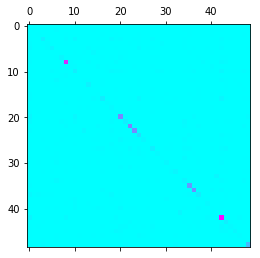

In [78]:
# TASK: Predict the outcome on the testing set in a variable named y_predicted
y_predicted = gs_clf.predict(docs_test)

print(gs_clf.best_params_)
print(cclf.score(docs_test, y_test))

# Print the classification report
print(metrics.classification_report(y_test, y_predicted,
                                    target_names=dataset.target_names))

# Plot the confusion matrix
cm = metrics.confusion_matrix(y_test, y_predicted)
#print(cm)

plt.matshow(cm, cmap=plt.cm.cool)
plt.show()

In [84]:
test_strings = [
    u'yawn',
    u'smile',
    u'happy',
    u'fun'
]

predicted = cclf.predict(test_strings)

for s, p in zip(test_strings, predicted):
    print(u'To feel these like ({}) try smoking {}'.format(s, dataset.target_names[p]))


To feel these like (yawn) try smoking purple-urkle
To feel these like (smile) try smoking amnesia-haze
To feel these like (happy) try smoking blue-dream
To feel these like (fun) try smoking ak-47
